# Load Data

In [0]:
#@title # Load MNIST Data
#@markdown ### Train data: 60000 samples
#@markdown * Input shape: (28, 28) -> 28x28 Image
#@markdown * Label shape: (5) -> Text label
#@markdown
#@markdown ### Train data: 10000 samples
#@markdown * Input shape: (28, 28) -> 28x28 Image
#@markdown * Label shape: (5) -> Text label
from IPython.display import clear_output
import tensorflow as tf
import numpy as np

index_to_character = [idx for idx in "Pabcdefghijklmnopqrstuvwxyz"]
character_to_index = {char: idx for idx, char in enumerate(index_to_character)}
label_to_text = [["z", "e", "r", "o", "P"], ["o", "n", "e", "P", "P"], ["t", "w", "o", "P", "P"],["t", "h", "r", "e", "e"], ["f", "o", "u", "r", "P"],
                         ["f", "i", "v", "e", "P"], ["s", "i", "x", "P", "P"], ["s", "e", "v", "e", "n"], ["e", "i", "g", "h", "t"],  ["n", "i", "n", "e", "P"]]
label_to_index_array = [[character_to_index[char] for char in txt] for txt in label_to_text]

def index_array_to_label(index_array):
    return [index_to_character[idx] for idx in index_array]

def prediction_to_label(prediction):
    return [index_array_to_label(idx_array) for idx_array in prediction.tolist()]

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = np.array([label_to_index_array[label] for label in y_train])
#y_test = np.array([label_to_index_array[label] for label in y_test])
y_train_onehot = np.array([np.eye(len(index_to_character))[y_train_elem] for y_train_elem in y_train])

clear_output()

# Build Model

In [0]:
#@title ## 1.Define Block
#@markdown * ### Input (input_shape, dtype)
#@markdown * ### Reshape(input_layer, input_shape)
#@markdown * ### CNN(input_layer, input_channel, output_channel, pool_shape)
#@markdown * ### FlatDense(input_layer, input_nodes, output_nodes)
#@markdown * ### Dense(input_layer, nodes, activation)
#@markdown * ### RNN(input_layer, hidden_nodes, initial_state)

def Input(input_shape, dtype):
    return tf.placeholder(dtype, [None] + input_shape)

def Reshape(input_layer, input_shape):
    return tf.reshape(input_layer, [-1] + input_shape + [1])

def CNN(input_layer, input_channel, output_channel, pool_shape):
    conv2d_filter = tf.Variable(tf.random_normal([5, 5, input_channel, output_channel], stddev=0.01))
    n = tf.nn.relu(tf.nn.conv2d(input_layer, filter=conv2d_filter, strides=[1, 1, 1, 1, ], padding='SAME'))
    return tf.nn.max_pool(n, ksize=[1] + pool_shape + [1], strides=[1] + pool_shape + [1], padding='SAME')

def FlatDense(input_layer, input_nodes, output_nodes):
    input_flat = tf.reshape(input_layer, [-1, input_nodes])
    w = tf.Variable(tf.random_normal([input_nodes, output_nodes], stddev=0.01))
    return tf.nn.relu(tf.matmul(input_flat, w))

def Dense(input_layer, nodes, activation):
    return tf.layers.dense(input_layer, nodes, activation=activation)

def RNN(input_layer, hidden_nodes, initial_state):
    rnn_cell = tf.nn.rnn_cell.BasicRNNCell(hidden_nodes)
    output, _ = tf.nn.dynamic_rnn(rnn_cell, input_layer, initial_state=initial_state, dtype=tf.float32)
    return output

In [0]:
#@title ## 2. Define Model
#@markdown * ## Encoder
#@markdown 1. ### ImageInput → CNN_Block_1
#@markdown 2. ### CNN_Block_1 → CNN_Block_2
#@markdown 3. ### CNN_Block_2 → FlatDense = Encoder State
#@markdown * ## Decoder
#@markdown 1. ### Input → RNN
#@markdown 2. ### RNN → Dense = Output

tf.reset_default_graph()

image_input = Input([28, 28], tf.float32)
image_reshape = Reshape(image_input, [28, 28])
cnn_block_1 = CNN(image_reshape, input_channel=1, output_channel=32, pool_shape=[2, 2])
cnn_block_2 = CNN(cnn_block_1, input_channel=32, output_channel=64, pool_shape=[2, 2])
encoder_state = FlatDense(cnn_block_2, 7 * 7 * 64, 128)

decoder_input = Input([5, len(index_to_character)], tf.float32)
decoder_target = Input([5], tf.int64)
decoder_output = RNN(decoder_input, 128, encoder_state)

model = Dense(decoder_output, len(index_to_character), activation=None)

clear_output()

In [0]:
#@title ## 3. Define Cost and Optimizer
#@markdown * ### Cost: Softmax Cross Entropy
#@markdown * ### Optimizer: Adam (Learning rate = 0.001)

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=decoder_target))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

clear_output()

In [5]:
#@title ## 1. Train Model

Epoch = 10 #@param {type:"integer"}
Batch_Size = 100 #@param {type:"integer"}

train_histroy = {'train_cost': []}

sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = x_train.shape[0] // Batch_Size

for epoch in range(Epoch):
    total_train_cost = 0
        
    for i in range(total_batch):
        input_batch = x_train[i * Batch_Size : (i+1) * Batch_Size]
        output_batch = y_train_onehot[i * Batch_Size : (i+1) * Batch_Size]
        target_batch = y_train[i * Batch_Size : (i+1) * Batch_Size]
            
        feed_dict={image_input: input_batch, decoder_input: output_batch, decoder_target: target_batch}    
        _, loss = sess.run([optimizer, cost], feed_dict=feed_dict)
        total_train_cost += loss
            
    train_histroy['train_cost'].append(total_train_cost / total_batch);

    print('Epoch: {0:04d} - '.format(epoch + 1), end='')
    print('Avg. cost: {0:.5f}, '.format(train_histroy['train_cost'][-1]))
        
print('Training done.')

Epoch: 0001 - Avg. cost: 0.13526, 
Epoch: 0002 - Avg. cost: 0.00572, 
Epoch: 0003 - Avg. cost: 0.00111, 
Epoch: 0004 - Avg. cost: 0.00035, 
Epoch: 0005 - Avg. cost: 0.00016, 
Epoch: 0006 - Avg. cost: 0.00009, 
Epoch: 0007 - Avg. cost: 0.00006, 
Epoch: 0008 - Avg. cost: 0.00004, 
Epoch: 0009 - Avg. cost: 0.00003, 
Epoch: 0010 - Avg. cost: 0.00002, 
Training done.


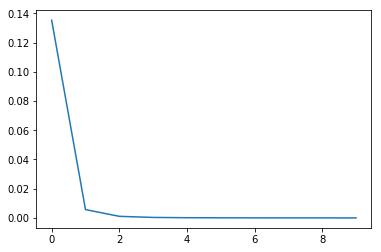

In [6]:
#@title ## 2. Plot Train Result
import matplotlib.pyplot as plt

plt.plot(train_histroy['train_cost'])
plt.show()

In [7]:
#@title ## 3. Test Prediction
Test_Begin_Index = 20 #@param {type:"integer"}
Test_End_Index = 50 #@param {type:"integer"}

input_test = x_test[Test_Begin_Index : Test_End_Index+1]
zeros = np.zeros((input_test.shape[0], 5, len(index_to_character)))
argmax = tf.argmax(model, 2)
prediction = sess.run(argmax, feed_dict={image_input: input_test, decoder_input: zeros})
    
for idx in range(Test_Begin_Index, Test_End_Index+1):
    label = index_array_to_label(prediction[idx - Test_Begin_Index])
    print("[Test {0:d}] {1:d} - ".format(idx, y_test[idx]), end='')
    print(''.join(label))

[Test 20] 9 - nineP
[Test 21] 6 - sixPP
[Test 22] 6 - sixPP
[Test 23] 5 - fiveP
[Test 24] 4 - fourP
[Test 25] 0 - zeroP
[Test 26] 7 - seven
[Test 27] 4 - fourP
[Test 28] 0 - zeroP
[Test 29] 1 - onePP
[Test 30] 3 - three
[Test 31] 1 - onePP
[Test 32] 3 - three
[Test 33] 4 - fourP
[Test 34] 7 - seven
[Test 35] 2 - twoPP
[Test 36] 7 - seven
[Test 37] 1 - onePP
[Test 38] 2 - twoPP
[Test 39] 1 - onePP
[Test 40] 1 - onePP
[Test 41] 7 - seven
[Test 42] 4 - fourP
[Test 43] 2 - twoPP
[Test 44] 3 - three
[Test 45] 5 - fiveP
[Test 46] 1 - onePP
[Test 47] 2 - twoPP
[Test 48] 4 - fourP
[Test 49] 4 - fourP
[Test 50] 6 - sixPP


In [0]:
#@title ## 4. Close Session
sess.close()